In [1]:
%load_ext autoreload
%autoreload 2
from tf_activation import DeepGraph
from tf_activation.models import mnist_cff as mnist_model

import math
import random
import os

import networkx as nx
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.metrics import r2_score
%matplotlib inline
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data

In [2]:
mnist_map = {
    0: 3,
    1: 2,
    2: 1,
    3: 18,
    4: 4,
    5: 8,
    6: 11,
    7: 0,
    8: 61,
    9: 7
}

CLUSTER_PATH = '../logdir/data/experiments/cluster_mnist'

SAVE_PATH = '../logdir/models'
ADV_PATH = '../logdir/adversaries/mnist_test_adversaries_19:50:09_18-09-17'
ELITE_PATH = '../logdir/elites'
DATA_PATH = '../logdir/data'
SAVE_FIG_LOC = '../logdir/figures'

centers = np.load(os.path.join(SAVE_PATH, 'average_mnist.npy'))
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allocator_type = 'BFC'
config.log_device_placement = False

persistence_module = tf.load_op_library('/home/tgebhart/python/tensorflow/bazel-bin/tensorflow/core/user_ops/nn_graph_persistence.so')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
im_1 = centers[:,1]
adv_1 = np.genfromtxt(os.path.join(ADV_PATH, '1_2.csv'), delimiter=',')

steps = 100

columns = ['in_distance', 'per_distance', 'cross_entropy', 'y_conv', 'accuracy']
index = range(steps)
test_df = pd.DataFrame(index=index, columns=columns)

In [4]:
def create_path(start_im, end_im, steps=100):
    ret = []
    t = np.divide(end_im - start_im, steps)
    for i in range(1,steps+1):
        ret.append(start_im + i*t)
    return ret
    

In [5]:
path = create_path(im_1, adv_1)
path.append(adv_1)

In [6]:
# setup model
with tf.device('/cpu:0'):
    # Create the model
    x = tf.placeholder(tf.float32, [None, 784])

    # Define loss and optimizer
    y_ = tf.placeholder(tf.float32, [None, 10])

    # Build the graph for the deep net
    net, keep_prob = mnist_model.deepnn(x)

    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=net['y_conv']))
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
    correct_prediction = tf.equal(tf.argmax(net['y_conv'], 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    saver = tf.train.Saver()

In [7]:
# run network
test_labels = np.stack((mnist.test.labels[mnist_map[1]],mnist.test.labels[mnist_map[1]]))
p = 99
with tf.Session(config=config) as sess:

    saver.restore(sess, os.path.join(SAVE_PATH, 'mnist_cff_2000.ckpt'))

    test_inputs = np.stack((im_1, path[0]))

    percentiles = persistence_module.layerwise_percentile([net['input'],
                                                        net['W_conv1'],
                                                        net['h_conv1'],
                                                        net['h_conv1'],
                                                        net['W_fc1'],
                                                        net['h_fc1'],
                                                        net['h_fc1_drop'],
                                                        net['W_fc2'],
                                                        net['y_conv']],
                                                        [0, 1, 2, 2, 1, 4, 4, 1, 4],
                                                        [p,p,p])

    ps1 = percentiles.eval(feed_dict={x: test_inputs[0:1], keep_prob:1.0})
    
    for i in range(len(path)):
        
        test_inputs = np.stack((im_1, path[i]))
        in_distance = np.linalg.norm(im_1 - path[i], ord=2)

        ps2 = percentiles.eval(feed_dict={x: test_inputs[1:2], keep_prob:1.0})

        result = persistence_module.wasserstein_distance([net['input'],
                                                        net['W_conv1'],
                                                        net['h_conv1'],
                                                        net['h_conv1'],
                                                        net['W_fc1'],
                                                        net['h_fc1'],
                                                        net['h_fc1_drop'],
                                                        net['W_fc2'],
                                                        net['y_conv']],
                                                        [0, 1, 2, 2, 1, 4, 4, 1, 4],
                                                        np.stack((ps1, ps2))
                                                        )


        per_distance = result.eval(feed_dict={x: test_inputs, keep_prob:1.0})
        print('Step: ', i)
        print('distance:', per_distance)
        
        ce = cross_entropy.eval(feed_dict={x:test_inputs[1:], y_:test_labels[1:], keep_prob:1.0})
        y_conv = sess.run(net['y_conv'], feed_dict={x:test_inputs[1:], keep_prob:1.0})
        acc = accuracy.eval(feed_dict={x:test_inputs[1:], y_:test_labels[1:], keep_prob:1})
        y_conv = y_conv / np.linalg.norm(y_conv)

        test_df.loc[i, 'in_distance'] = in_distance
        test_df.loc[i, 'per_distance'] = per_distance[0]
        test_df.loc[i, 'cross_entropy'] = ce
        test_df.loc[i, 'y_conv'] = y_conv[0,np.argmax(test_labels[1], axis=0)]
        test_df.loc[i, 'accuracy'] = acc
        

INFO:tensorflow:Restoring parameters from ../logdir/models/mnist_cff_2000.ckpt
('Step: ', 0)
('distance:', array([ 320187.3125], dtype=float32))
('Step: ', 1)
('distance:', array([ 271377.6875], dtype=float32))
('Step: ', 2)
('distance:', array([ 410823.96875], dtype=float32))
('Step: ', 3)
('distance:', array([ 638330.125], dtype=float32))
('Step: ', 4)
('distance:', array([ 936638.5625], dtype=float32))
('Step: ', 5)
('distance:', array([ 1284684.25], dtype=float32))
('Step: ', 6)
('distance:', array([ 1598719.125], dtype=float32))
('Step: ', 7)
('distance:', array([ 1905915.], dtype=float32))
('Step: ', 8)
('distance:', array([ 2215636.5], dtype=float32))
('Step: ', 9)
('distance:', array([ 2618114.], dtype=float32))
('Step: ', 10)
('distance:', array([ 3060163.25], dtype=float32))
('Step: ', 11)
('distance:', array([ 3466389.25], dtype=float32))
('Step: ', 12)
('distance:', array([ 3716697.5], dtype=float32))
('Step: ', 13)
('distance:', array([ 4017623.], dtype=float32))
('Step: '

In [8]:
test_df.tail()

,in_distance,per_distance,cross_entropy,y_conv,accuracy
96,4.88676,7.16877e+06,0.00556064,0.88022,1
97,4.93714,7.16791e+06,0.00531937,0.879425,1
98,4.98752,7.1691e+06,0.0050944,0.878578,1
99,5.0379,7.17159e+06,0.00487769,0.877749,1
100,5.0379,7.17159e+06,0.00487769,0.877749,1


In [9]:
def regress(X, y, xlab, ylab, color_vals='b'):
    
    print(X.shape,y.shape)
    
    # Split the data into training/testing sets
    X_train = X[:-20]
    X_test = X[-20:]

    # Split the targets into training/testing sets
    y_train = y[:-20]
    y_test = y[-20:]

    # Create linear regression object
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(X_train, y_train)

    # The coefficients
    print('Coefficients: ', regr.coef_)
    # The mean squared error
    print("Mean squared error: %.2f"
          % np.mean((regr.predict(X_test) - y_test) ** 2))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % regr.score(X_test, y_test))
    print('R^2: %.2f' % r2_score(y_test, regr.predict(X_test)))
    
    fig, ax = plt.subplots()
    X_min = np.min(X)
    X_max = np.max(X)
    y_min = np.min(y)
    y_max = np.max(y)
    # Plot outputs
    
    ax.scatter(X, y,  color=color_vals, s=7)
#     ax.plot(X, regr.predict(X), color='blue', linewidth=3)


    ax.set_xlim(X_min, X_max)
    ax.set_ylim(y_min, y_max)
    
    plt.xlabel(xlab)
    plt.ylabel(ylab)
#     plt.title('{} vs {}'.format(xlab, ylab))
    plt.show()
    fig.savefig(os.path.join(SAVE_FIG_LOC, xlab + '_' + ylab + '.svg'), 
                format='svg', dpi=1200, bbox_inches='tight')


((101, 1), (101,))
('Coefficients: ', array([ 1392494.25299545]))
Mean squared error: 4778005470885.75
Variance score: -1344476.96
R^2: -1344476.96


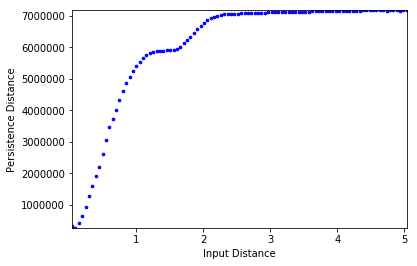

In [10]:
X = test_df['in_distance'].as_matrix()
X = X.reshape((X.shape[0], 1))
y = test_df['per_distance'].as_matrix()
regress(X, y, 'Input Distance', 'Persistence Distance')

((101, 1), (101,))
('Coefficients: ', array([-10416084.31406524]))
Mean squared error: 362702378651.93
Variance score: -102059.44
R^2: -102059.44


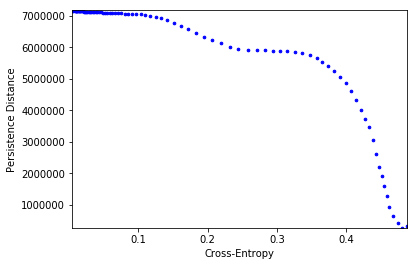

In [11]:
X = test_df['cross_entropy'].as_matrix()
X = X.reshape((X.shape[0], 1))
regress(X, y, 'Cross-Entropy', 'Persistence Distance')

((101, 1), (101,))
('Coefficients: ', array([ 39169365.04598249]))
Mean squared error: 100411839758.37
Variance score: -28253.78
R^2: -28253.78


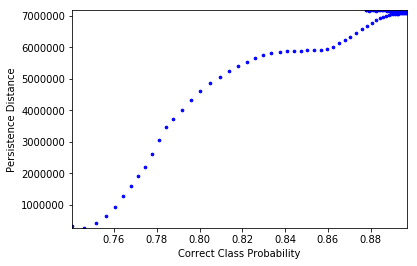

In [12]:
X = test_df['y_conv'].as_matrix()
X = X.reshape((X.shape[0], 1))
regress(X, y, 'Correct Class Probability', 'Persistence Distance')

((101, 1), (101,))
('Coefficients: ', array([ 0.03714969]))
Mean squared error: 0.00
Variance score: -296.34
R^2: -296.34


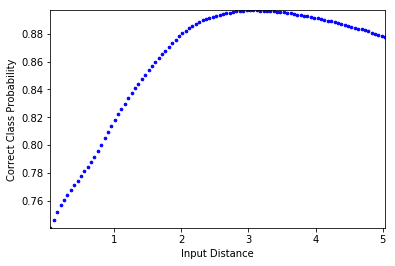

In [13]:
X = test_df['in_distance'].as_matrix()
X = X.reshape((X.shape[0], 1))
y = test_df['y_conv'].as_matrix()
regress(X, y, 'Input Distance', 'Correct Class Probability')